# Fundamental Frequency Estimation

<!-- The two most common basic approaches to $F_0$ estimation from speech:
- autocorrelation method

- the cepstral method -->

In this section, we focus on fundamental frequency estimation (denoted as $F_0$), which refers to the process of estimating the pitch of speech signals. The fundamental frequency is an essential feature in speech processing, as it is closely related to the perceived pitch and plays a critical role in applications such as speaker identification, speech synthesis, and prosody analysis.

Two of the most common basic approaches for $F_0$ estimation are:

- **Autocorrelation Method**: This method relies on computing the autocorrelation of the speech signal over short frames. The periodicity of voiced speech causes peaks in the autocorrelation function, and the lag corresponding to the first peak indicates the fundamental frequency. This approach is widely used because it is simple and robust in detecting periodic components of speech.

- **Cepstral Method**: In this method, the speech signal is transformed into the cepstral domain by taking the inverse Fourier transform of the logarithm of the signal’s spectrum. The fundamental frequency appears as a peak in the cepstrum, which can be detected to estimate $F_0$. The cepstral method is particularly useful for distinguishing between periodic and aperiodic components of speech, making it effective for more complex speech signals.

Both methods are widely used due to their simplicity and effectiveness, though they have different strengths and weaknesses depending on the nature of the speech signal and the application context. This section will explore these methods and demonstrate their application in estimating the fundamental frequency from speech data.

In [4]:
from utils import *

In [5]:
data, Fs = loading('hello.wav', 16000)

In [9]:
frame_length_ms = 25 # in miliseconds
hop_length_ms = 12.5 # in miliseconds

frame_length = int(np.around((frame_length_ms/1000)*Fs))# 50ms in samples
hop_size = int(np.around((hop_length_ms/1000)*Fs))# 12.5 ms in samples (12.5/50 % overlap)

In [10]:
frame_matrix = windowing(data, frame_length, hop_size, 'hamming')

In [11]:
frame_matrix.shape

(400, 311)

## autocorrelation

In [12]:
def F0_autocorr(frame,fs,f0_min,f0_max,vuv_threshold):
    #F0_AUTOCORR Fundamental frequency estimation with the autocorrelation method.
    # Inputs:   'frame': Windowed signal segment
    #           'fs': sampling frequency
    #           'f0_min' and 'f0_max': Given in Hz, represent the search space for the F0 values          
    #           'vuv_threshold': Heuristic value that acts as a classifier
    #           between voiced and unvoiced frames. A frame is classified as 
    #           unvoiced if the strength of the autocorrelation peak is smaller than vuv_threshold.
    #           
    # Outputs: 'f0': Estimated fundamental frequency (in Hz) for the given frame
    #          'ac_peak_val': The amplitude of the autocorrelation peak value

    frame = np.array(frame)
    frame = frame-np.mean(frame)#Remove mean to omit effect of DC component
    #Number of autocorrelation lag samples corresponding to f0_min (i.e. maximum
    # period length)
    max_lag = int(np.ceil(fs/f0_min))
    #Number of autocorrelation lag samples corresponding to f0_max (i.e. minimum
    # period length)
    min_lag = int(np.floor(fs/f0_max))

    #Compute autorrelation sequence up to max_lag
    r = np.correlate(frame,frame, mode='full')
    r = r/np.amax(np.absolute(r))
    r = r[len(frame):]
    r = r[min_lag:max_lag]

    # Locate autocorrelation peak and its amplitude between min_lag and max_lag
    #r = r[min_lag:]
    ac_peak_val = np.amax(r)
    ind = np.argmax(r)

    if ac_peak_val > vuv_threshold:
        f0 = fs/(min_lag+ind)
    else:
        f0 = 0

    return f0,ac_peak_val

In [13]:
# 1. Define minimum and maximum values for the F0 search range, and the threshold value for 
# Voiced/Unvoiced decision. 
f0_max = 180 #Hz
f0_min = 50 #Hz
vuv_threshold_ac = 0.22

# 2. Write a loop through frame_matrix that calls the function F0_autocorr to obtain
# the F0 estimates for each frame

f0vec_ac = np.zeros((len(frame_matrix[0]),1)) # Allocate f0 vector for autocorrelation method
ac_peak_vec = np.zeros((len(frame_matrix[0]),1)) # Allocate vector for ac peak amplitude vector


# 3. You need to implement 'F0_autocorr' function (below cell)

for iFrame in range(len(frame_matrix[0])):
    f0vec_ac[iFrame], ac_peak_vec[iFrame] = F0_autocorr(frame_matrix[:,iFrame], Fs, f0_min, f0_max, vuv_threshold_ac)

## cepstral

The real cepstrum of a signal $s[n]$ is defined as:

\begin{equation}
  c[m] = \mathcal{F}^{-1}(\log(|\mathcal{F}(s[n])|^2)),
\end{equation}

In [14]:
def F0_cepstrum(frame,fs,f0_min,f0_max,vuv_threshold):
    #F0_CEPSTRUM Fundamental frequency estimation with the cepstrum method.
    # Inputs:   'frame': Windowed signal segment.
    #           'fs': sampling frequency.
    #           'f0_min' and 'f0_max': Given in Hz, represent the search space for the F0 values.
    #           'vuv_threshold': Heuristic value that acts as a classifier between voiced and unvoiced frames.
    #            A frame is classified as unvoiced if the strength of the cepstral peak is smaller than vuv_threshold.
    #           
    # Outputs:  'f0': Estimated fundamental frequency (in Hz) for the given frame.
    #           'ceps_peak_val': The amplitude of the cepstral peak value.

    frame = np.array(frame)
    frame = frame-np.mean(frame)#Remove mean to omit effect of DC component

    #Number of autocorrelation lag samples corresponding to f0_min (i.e. maximum
    # period length)
    max_lag = int(np.ceil(fs/f0_min))
    #Number of autocorrelation lag samples corresponding to f0_max (i.e. minimum
    # period length)
    min_lag = int(np.floor(fs/f0_max))

    eps = 0.00001#Add this to the power spectrum to ensure values are above zero for log function

    #Compute real cepstrum of frame
    c = np.fft.ifft(np.log10(np.power(np.absolute(np.fft.fft(frame)),2) + eps))

    #Locate cepstral peak and its amplitude between min_lag and max_lag
    c = c[min_lag:max_lag]
    cepstral_peak_val = np.amax(np.absolute(c))
    ind = np.argmax(c)

    if cepstral_peak_val > vuv_threshold:
        f0 = fs/(min_lag+ind)
    else:
        f0 = 0

    return f0,cepstral_peak_val

In [15]:
# 1. Define the threshold value for Voiced/Unvoiced decision.
vuv_threshold_ceps = 0.035
f0vec_ceps = np.zeros((len(frame_matrix[0]),1)) # Allocate f0 vector for cepstrum method
ceps_peak_vec = np.zeros((len(frame_matrix[0]),1)) # Allocate vector for cepstral peak vector

# 2. You need to implement 'F0_cepstrum' function (below cell)

for iFrame in range(len(frame_matrix[0])):
    f0vec_ceps[iFrame], ceps_peak_vec[iFrame] = F0_cepstrum(frame_matrix[:,iFrame], Fs, f0_min, f0_max, vuv_threshold_ceps)

## Visualization

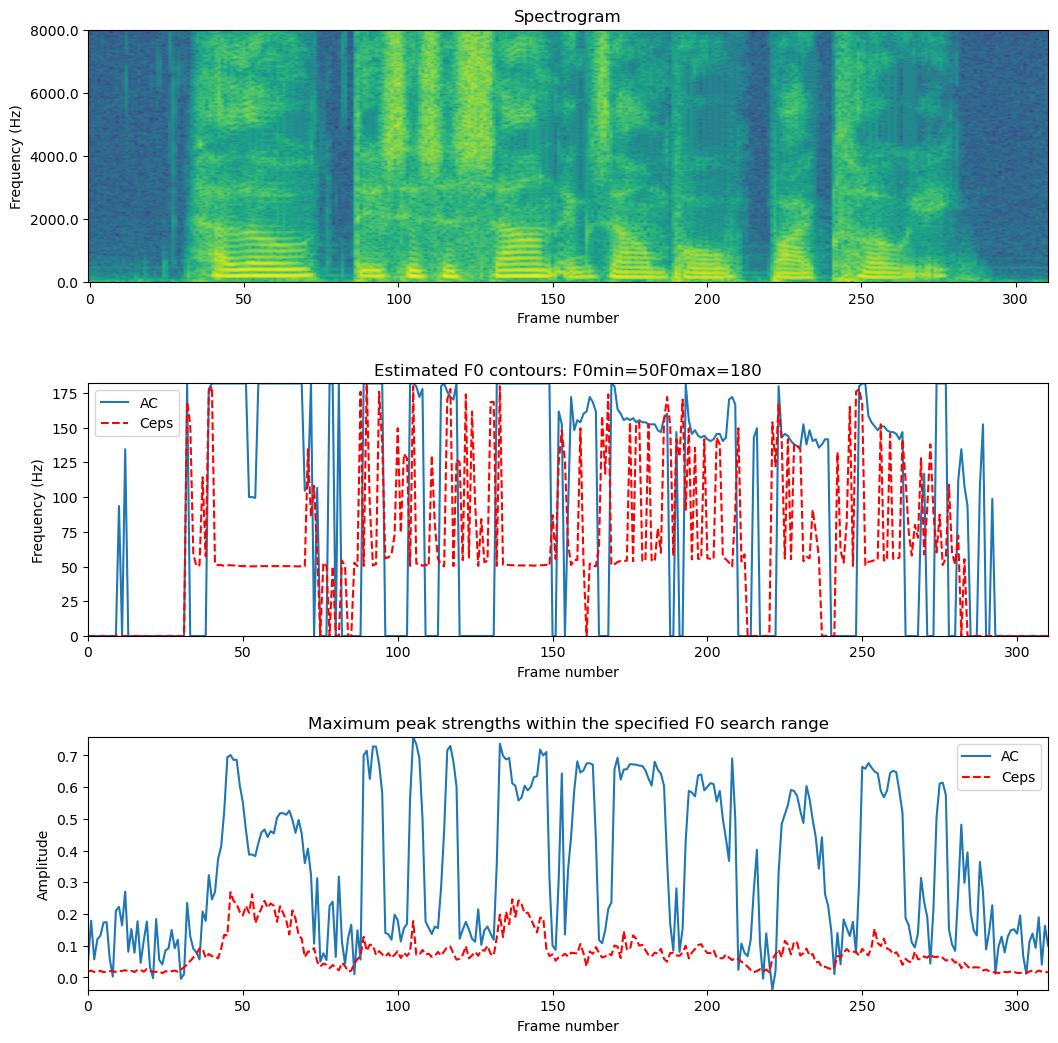

In [16]:
# visualize your results
Nfft = 1024

fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize=(12, 12))
fig.tight_layout()

# 1. Plot the spectrogram of the original signal.
plt.subplot(3, 1, 1)
frame_matrix_fft = np.fft.rfft(frame_matrix, axis=0, n=Nfft) #513 * 216
frame_matrix_fft = 20 * np.log10(np.absolute(np.flipud(frame_matrix_fft))) # 512 * 216
plt.imshow(frame_matrix_fft, aspect='auto')
f_axis = np.divide(range(int(Nfft / 2) + 1), (Nfft/2)/(Fs/2))
ytickpos = np.flipud(np.linspace(0, Nfft/2,5)).astype(int)
plt.yticks(np.linspace(0, Nfft/2,5), f_axis[ytickpos])
plt.title('Spectrogram')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Frame number')

# 2. Plot the estimated F0 vectors. Report F0max and F0min within the title
plt.subplot(3, 1, 2)
plt.plot(f0vec_ac)
plt.plot(f0vec_ceps,'r--')
plt.autoscale(enable = True, axis = 'both', tight = True)
plt.legend(('AC','Ceps'))
plt.title('Estimated F0 contours: F0min=' + str(f0_min) + 'F0max=' + str(f0_max))
plt.xlabel('Frame number')
plt.ylabel('Frequency (Hz)')

# 3. Plot the peak amplitudes of the cepstral peak and the autocorrelation peak
plt.subplot(3, 1, 3)
plt.plot(ac_peak_vec)
plt.plot(ceps_peak_vec,'r--')
plt.autoscale(enable = True, axis = 'both', tight = True)
plt.legend(('AC','Ceps'))
plt.title('Maximum peak strengths within the specified F0 search range')
plt.xlabel('Frame number')
plt.ylabel('Amplitude')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show(block=False)